In [20]:
using Pkg
Pkg.add("Plots")

using Plots

  Resolving package versions...
   Updating `/opt/julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `/opt/julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `/opt/julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `/opt/julia/environments/v1.4/Manifest.toml`
 [no changes]
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


In [28]:
mutable struct Word2Vec
    veclen::Int64
    vocab::Array{String}
    vectors::Dict{String,Vector{Float64}}
end

Here we define our Word2Vec structure as mutable (so that it's contents can be modified). 

The contents of this structure are:
 - veclen: size of the individual word vectors.
 - vocab: array holding all the words parsed (i.e. the vocabulary)
 - vectors: dictionary mapping a word to it's vector


In [29]:
function readdata(data::String, veclen::Int64)
    word2vec = Word2Vec(veclen, [], Dict())
    onlywords = r"^[a-z]+$"

    for line in split(data, "\r\n")
        line = lowercase(line)
        line = replace(line, r"[\.,\":“”;]" => s"")
        line = replace(line, r"[\-—]" => s" ")
        line = replace(line, r"'s" => s" ")
        words = split(line)
        for word in words
            if (match(onlywords, word) != nothing)
                push!(word2vec.vocab, word)
                if !haskey(word2vec.vectors, word)
                    word2vec.vectors[word] = Vector(rand(veclen))
                end
            end
        end
    end
    word2vec
end

readdata (generic function with 1 method)

This function reads the data from string passed as a parameter by reading each line at a time and then extracting the words from the line in a naive way. The parameter veclen is used to define the length of the individual word vectors.

The words vectors are initialized to random values.

In [11]:
function p(theta::Word2Vec, len::Int64, o::String, c::String) Float64
    num = exp(transpose(theta.vectors[o]) * theta.vectors[c])
    denom = 0.0
    for v=1:len
        denom += exp(transpose(theta.vectors[theta.vocab[v]]) * theta.vectors[c])
    end
    num / denom
end

p (generic function with 1 method)

This function computes a probaility for two words being adjacent to each other in the text. It is in essense 
an implementation of the softmax algorithm. The dot products (which if you recall your linear algebra is the cosine 
of the angle between the two vectors) is used for this purpose.

In [12]:
function gradient(theta::Word2Vec, len::Int64, o::String, c::String) Float64
    num = Vector(zeros(len))
    denom = 0.0
    v_c = theta.vectors[c]
    u_o = theta.vectors[o]
    for i = 1:len
        u_x = theta.vectors[theta.vocab[i]]
        num += exp(transpose(u_x) * v_c) * u_x
        denom += exp(transpose(u_x) * v_c)
    end

    result = u_o - num / denom
end

gradient (generic function with 1 method)

This is gradient computation. To Do - show dervation.

In [13]:
function likelihood(theta::Word2Vec, len::Int64, m::Int64 = 3) Float64
    result = 0.0
    for i = 1:len
        for j = -m:m
            if ((j != 0) && (i + j > 0) && (i + j <= len))
                result += log(p(theta, len, theta.vocab[i + j], theta.vocab[i]))
            end
        end
    end
    -result / len
end

likelihood (generic function with 2 methods)

This is an implementation of the likelihood function as described in the lecture. To Do - better explanation.

In [14]:
function gradient_descent(theta::Word2Vec, len::Int64, m::Int64 = 3, lr::Float64 = 0.1)
    for i=1:len
        w_c = theta.vocab[i]
        for j = -m:m
            if ((j != 0) && (i + j > 0) && (i + j <= len))
                w_o = theta.vocab[i + j]
                grad = gradient(theta, len, w_o, w_c)
                theta.vectors[w_o] = theta.vectors[w_o] - grad * lr
            end
        end
    end

    likelihood(theta, len, m)
end

gradient_descent (generic function with 3 methods)

This is a basic implementation of gradient descent. To Do - give better explanation of this

In [23]:
function scatter_plot(word2vec::Word2Vec, len::Int64)
    x = Array{Float64,1}()
    y = Array{Float64,1}()
    words = Array{String,1}()

    for i=1:len
        w_c = word2vec.vocab[i]
        append!(x, word2vec.vectors[w_c][1])
        append!(y, word2vec.vectors[w_c][1])
        push!(words, w_c)
    end
    display(scatter(x,y, series_annotations=words, title = "Word2Vec Plot"))
end

scatter_plot (generic function with 1 method)

In [27]:
emmaNovel = """Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings of
existence; and had lived nearly twenty-one years in the world with very
little to distress or vex her.

She was the youngest of the two daughters of a most affectionate,
indulgent father; and had, in consequence of her sister's marriage, been
mistress of his house from a very early period. Her mother had died
too long ago for her to have more than an indistinct remembrance of
her caresses; and her place had been supplied by an excellent woman as
governess, who had fallen little short of a mother in affection.

Sixteen years had Miss Taylor been in Mr. Woodhouse's family, less as a
governess than a friend, very fond of both daughters, but particularly
of Emma. Between _them_ it was more the intimacy of sisters. Even before
Miss Taylor had ceased to hold the nominal office of governess, the
mildness of her temper had hardly allowed her to impose any restraint;
and the shadow of authority being now long passed away, they had been
living together as friend and friend very mutually attached, and Emma
doing just what she liked; highly esteeming Miss Taylor's judgment, but
directed chiefly by her own.

The real evils, indeed, of Emma's situation were the power of having
rather too much her own way, and a disposition to think a little too
well of herself; these were the disadvantages which threatened alloy to
her many enjoyments. The danger, however, was at present so unperceived,
that they did not by any means rank as misfortunes with her.

Sorrow came--a gentle sorrow--but not at all in the shape of any
disagreeable consciousness.--Miss Taylor married. It was Miss Taylor's
loss which first brought grief. It was on the wedding-day of this
beloved friend that Emma first sat in mournful thought of any
continuance. The wedding over, and the bride-people gone, her father and
herself were left to dine together, with no prospect of a third to cheer
a long evening. Her father composed himself to sleep after dinner, as
usual, and she had then only to sit and think of what she had lost.
"""

"Emma Woodhouse, handsome, clever, and rich, with a comfortable home\nand happy disposition, seemed to unite some of the best blessings of\nexistence; and had lived nearly twenty-one years in the world with very\nlittle to distress or vex her.\n\nShe was the youngest of the two daughters of a most affectionate,\nindulgent father; and had, in consequence of her sister's marriage, been\nmistress of his house from a very early period. Her mother had died\ntoo long ago for her to have more than an indistinct remembrance of\nher caresses; and her place had been supplied by an excellent woman as\ngoverness, who had fallen little short of a mother in affection.\n\nSixteen years had Miss Taylor been in Mr. Woodhouse's family, less as a\ngoverness than a friend, very fond of both daughters, but particularly\nof Emma. Between _them_ it was more the intimacy of sisters. Even before\nMiss Taylor had ceased to hold the nominal office of governess, the\nmildness of her temper had hardly allowed her 

This function is used to do the plot.

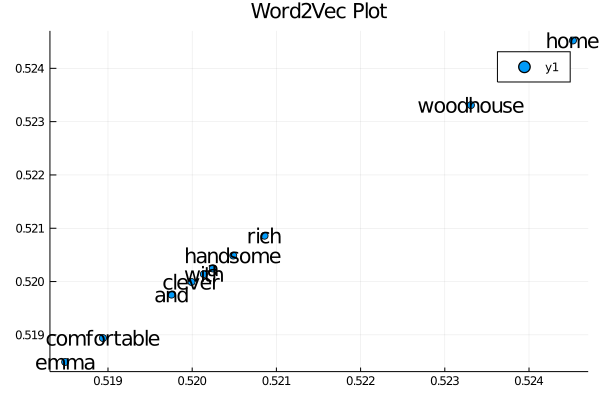

Epoch: 1 11.420301376942485
Epoch: 2 11.218653049704113
Epoch: 3 11.13634369864061
Epoch: 4 11.098389116116321
Epoch: 5 11.079124200457887
Epoch: 6 11.068572077681285
Epoch: 7 11.062453360115061
Epoch: 8 11.058760104822262
Epoch: 9 11.056469725459596
Epoch: 10 11.05502385429174


In [42]:
len = 10
epochs = 10
word2vec = readdata(emmaNovel, len)
for i = 1:epochs
    println("Epoch: ", i, " ", gradient_descent(word2vec, len))
end
scatter_plot(word2vec, len)